In [6]:
!pip install pandas numpy yfinance statsmodels matplotlib


In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


Enter the stock ticker symbol (e.g., TSLA for Tesla): AAPL
Enter the prediction date (YY-MM-DD): 24-12-06


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step - loss: 0.2501 - val_loss: 0.0485
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 0.0171 - val_loss: 0.0128
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.0129 - val_loss: 0.0446
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0098 - val_loss: 0.0311
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0049 - val_loss: 0.0054
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0046 - val_loss: 0.0113
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0037 - val_loss: 0.0182
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0037 - val_loss: 0.0090
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0035 - val_loss: 0.0075
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0035 - val_loss: 0.0096
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0034 - val_loss: 0.0103
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0032 - val_lo

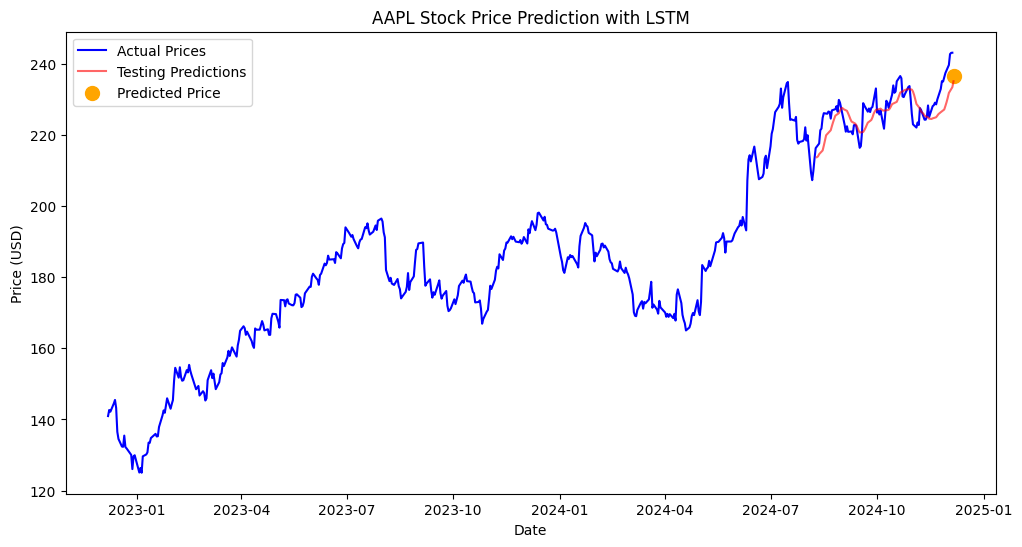

In [8]:
# Function to fetch stock data from Yahoo Finance
def get_data_from_yahoo(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
    return data

# User input for stock ticker and prediction date
ticker = input("Enter the stock ticker symbol (e.g., TSLA for Tesla): ")
prediction_date_input = input("Enter the prediction date (YY-MM-DD): ")

# Convert the prediction date to a datetime object by adding '20' to the year
try:
    prediction_date = datetime.strptime('20' + prediction_date_input, "%Y-%m-%d").date()
except ValueError:
    print("Invalid date format. Please use the format 'YY-MM-DD'.")
    prediction_date = None

if prediction_date:
    # Calculate the start date (2 years before the prediction date)
    start_date = prediction_date - timedelta(days=2 * 365)
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = prediction_date.strftime("%Y-%m-%d")

    # Fetch stock data
    data = get_data_from_yahoo(ticker, start_date_str, end_date_str)

    # Check if data is sufficient
    if len(data) < 60:
        print("Not enough data available. At least 60 data points are required.")
    else:
        # Prepare the data
        data["Date"] = data.index
        data = data[["Date", "Close"]].dropna()

        # Normalize the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data["Close"].values.reshape(-1, 1))

        # Create sequences for LSTM
        def create_sequences(data, sequence_length):
            X, y = [], []
            for i in range(len(data) - sequence_length):
                X.append(data[i:i + sequence_length])
                y.append(data[i + sequence_length])
            return np.array(X), np.array(y)

        sequence_length = 100  # Using last 60 days to predict the next day
        X, y = create_sequences(scaled_data, sequence_length)

        # Split the data into training and testing sets
        split_point = int(len(X) * 0.8)
        X_train, y_train = X[:split_point], y[:split_point]
        X_test, y_test = X[split_point:], y[split_point:]

        # Build the LSTM model
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
            LSTM(50, return_sequences=False),
            Dense(25),
            Dense(1)
        ])
        model.compile(optimizer="adam", loss="mean_squared_error")

        # Train the model
        model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), verbose=1)

        # Predict on testing data
        y_test_pred = model.predict(X_test)
        y_test_pred = scaler.inverse_transform(y_test_pred)  # De-normalize predictions
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # De-normalize actual values

        # Predict stock price for the given prediction date
        last_sequence = scaled_data[-sequence_length:]  # Use the last 60 days
        last_sequence = np.expand_dims(last_sequence, axis=0)
        predicted_price_scaled = model.predict(last_sequence)
        predicted_price = scaler.inverse_transform(predicted_price_scaled)

        # Display predicted price
        print(f"Predicted stock price for {ticker} on {prediction_date.strftime('%Y-%m-%d')}: ${predicted_price[0][0]:.2f}")

        # Evaluate the model
        def evaluate_model(y_true, y_pred, dataset_type):
            mae = mean_absolute_error(y_true, y_pred)
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            print(f"{dataset_type} Performance:")
            print(f"Mean Absolute Error (MAE): {mae:.2f}")
            print(f"Mean Squared Error (MSE): {mse:.2f}")
            print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

        evaluate_model(y_test_actual, y_test_pred, "Testing")

        # Convert predictions to 1D array for plotting
        y_test_pred_flat = y_test_pred.flatten()

        # Ensure the length of dates matches the predictions
        testing_dates = data["Date"].iloc[split_point:split_point + len(y_test_pred_flat)]

        # Calculate the required shift to align the last test date with the prediction date
        last_test_date = data["Date"].iloc[split_point + len(y_test_pred_flat) - 1].date()  # Convert to datetime.date
        days_to_shift = (prediction_date - last_test_date).days

        # Shift the testing dates
        shifted_testing_dates = data["Date"].iloc[split_point:split_point + len(y_test_pred_flat)] + pd.Timedelta(days=days_to_shift)

        # Plot the data
        plt.figure(figsize=(12, 6))
        plt.plot(data["Date"], data["Close"], label="Actual Prices", color="blue")
        plt.plot(shifted_testing_dates, y_test_pred_flat, label="Testing Predictions", color="red", alpha=0.6)
        plt.scatter(prediction_date, predicted_price[0][0], color="orange", label="Predicted Price", s=100)
        plt.title(f"{ticker} Stock Price Prediction with LSTM")
        plt.xlabel("Date")
        plt.ylabel("Price (USD)")
        plt.legend()
        plt.show()

